## Freeverb
#### Annie Chu | October 18, 2021
Implementing Freeverb algorithms

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import simpleaudio as sa
from matplotlib.pyplot import figure

#### Feedback Comb & All Pass Filters via Difference Equations

In [5]:
# creating feedback comb filter
def comb(x_n, g, d):
    # x_n is numpy array of initial samples
    y_n = np.zeros(len(x_n));
    for i in range(len(x_n)):
        if i-d < 0:
            y_n[i] = x_n[i]
        else:
            y_n[i] = x_n[i] + g*y_n[i-d]
    return y_n

In [6]:
#testing comb
x1 = np.array([1.0, 0.1, -0.1])

y1 = comb(x1, 0.5, 1)
y2 = comb(x1, 0.5, 1)

print(y1)
print(y1+y2)

[1.  0.6 0.2]
[2.  1.2 0.4]


In [7]:
# creating all pass filter
def allpass(x_n, g, d):
    # x_n is numpy array of initial samples
    y_n = np.zeros(len(x_n));
    for i in range(len(x_n)):
        if i-d < 0:
            y_n[i] = g*x_n[i]
        else:
            y_n[i] = g*x_n[i] + x_n[i-d] - g*y_n[i-d]
    return y_n

In [8]:
#testing all pass
x1 = np.array([1.0, 0.1, -0.1])

allpass(x1, 0.5, 1)

array([ 0.5 ,  0.8 , -0.35])

In [9]:
# creating lowpass feedback comb filter (Schroeder-Moorer)
def lp_comb(x_n, g, d, sg):
    # x_n is numpy array of initial samples
    # g = damp = initialdamp*scaledamp
    # sg is secondary gain -- sg = room size = initialroom*scaleroom + offsetroom
    y_n = np.zeros(len(x_n));
    for i in range(len(x_n)):
        if i-d < 0:
            y_n[i] = x_n[i]
        else:
            y_n[i] = x_n[i] - g*x_n[i-1] + g*y_n[i-1] + sg*(1-g)*y_n[i-d]
    return y_n

In [10]:
#testing lp_comb
x1 = np.array([1.0, 0.1, -0.1])

y1 = lp_comb(x1, 0.5, 1, 0.7)
y2 = lp_comb(x1, 0.5, 1, 0.7)

print(y1)
print(y1+y2)

[1.     0.45   0.2325]
[2.    0.9   0.465]


### Creating Reverb Class

In [16]:
JCREV.x = x
JCREV.rev()

array([ 2.072 ,  0.2072, -0.2072])

In [182]:
class Freeverb:
    kind = 'freeverb'
    
    def __init__(self, name, gc, sgc, dc, gap, dap, gx):
        self.name = name
        self.gc = gc
        self.sgc = sgc
        self.dc1 = dc[0]
        self.dc2 = dc[1]
        self.dc3 = dc[2]
        self.dc4 = dc[3]
        self.dc5 = dc[4]
        self.dc6 = dc[5]
        self.dc7 = dc[6]
        self.dc8 = dc[7]
        self.gap = gap
        self.dap1 = dap[0]
        self.dap2 = dap[1]
        self.dap3 = dap[2]
        self.dap4 = dap[3]
        self.gx = gx
        self.x = 0 #2 channel input
        self.leftx = 0
        self.rightx = 0
        self.yc_out = 0
        self.yap3 = 0
        self.ly_final = 0
        self.ry_final = 0
        self.ss = 23 #stereo spread

        
    def left_rev(self):
        self.leftx = self.x[:,0]
        yc1 = lp_comb(self.leftx, self.gc, self.dc1, self.sgc) 
        yc2 = lp_comb(self.leftx, self.gc, self.dc2, self.sgc)
        yc3 = lp_comb(self.leftx, self.gc, self.dc3, self.sgc)
        yc4 = lp_comb(self.leftx, self.gc, self.dc4, self.sgc)
        yc5 = lp_comb(self.leftx, self.gc, self.dc5, self.sgc)
        yc6 = lp_comb(self.leftx, self.gc, self.dc6, self.sgc)
        yc7 = lp_comb(self.leftx, self.gc, self.dc7, self.sgc)
        yc8 = lp_comb(self.leftx, self.gc, self.dc8, self.sgc)

        yc_out = yc1 + yc2 + yc3 + yc4 + yc5 + yc6 + yc7 + yc8

        yap1 = allpass(yc_out, self.gap, self.dap1)
        yap2 = allpass(yap1, self.gap, self.dap2)
        yap3 = allpass(yap2, self.gap, self.dap3)
        yap4 = allpass(yap2, self.gap, self.dap4)


        self.ly_final = yap4 + (self.gx*self.leftx)
        return self.ly_final
    
    def right_rev(self):
        self.rightx = self.x[:,1]
        yc1 = lp_comb(self.rightx, self.gc, self.dc1+self.ss, self.sgc) 
        yc2 = lp_comb(self.rightx, self.gc, self.dc2+self.ss, self.sgc)
        yc3 = lp_comb(self.rightx, self.gc, self.dc3+self.ss, self.sgc)
        yc4 = lp_comb(self.rightx, self.gc, self.dc4+self.ss, self.sgc)
        yc5 = lp_comb(self.rightx, self.gc, self.dc5+self.ss, self.sgc)
        yc6 = lp_comb(self.rightx, self.gc, self.dc6+self.ss, self.sgc)
        yc7 = lp_comb(self.rightx, self.gc, self.dc7+self.ss, self.sgc)
        yc8 = lp_comb(self.rightx, self.gc, self.dc8+self.ss, self.sgc)

        yc_out = yc1 + yc2 + yc3 + yc4 + yc5 + yc6 + yc7 + yc8

        yap1 = allpass(yc_out, self.gap, self.dap1+self.ss)
        yap2 = allpass(yap1, self.gap, self.dap2+self.ss)
        yap3 = allpass(yap2, self.gap, self.dap3+self.ss)
        yap4 = allpass(yap2, self.gap, self.dap4+self.ss)


        self.ry_final = yap4 + (self.gx*self.rightx)
        return self.ry_final
    

In [162]:
x = np.array([[1,2],[4,5],[7,8]])
print(type(x))
print(x[:,0])
print(x[:,1])

<class 'numpy.ndarray'>
[1 4 7]
[2 5 8]


In [163]:
test = Freeverb(
   'Freeverb', 
   0.2, #gc
   0.84, #sgc 
   [1557, 1617, 1491, 1422, 1277, 1356, 1188, 1116], #dc
   0.5, #gap 
   [225, 556, 441, 341],#dap 
   0.7,     #gx
)

In [164]:
print(test.kind)
print(test.dc1)
print(type(test.gx))

freeverb
1557
<class 'float'>


In [165]:
test.x = x

In [166]:
test.left_rev()

array([1., 4., 7.])

==============================



==============================

In [167]:
audiofile = "/Users/anniechu/Desktop/twochannel.wav"
fs, data = wavfile.read(audiofile)

<ipython-input-167-70d904e2fc83>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(audiofile)


In [168]:
#checking cb_data contents
print(f".Wav Contents = {data}")
print(f".Wav Shape = {data.shape}")
length = data.shape[0] / fs
print(f".Wav Length = {length}s")
print(f"Sampling Rate= {fs} Hz")


.Wav Contents = [[ 0  0]
 [ 0  0]
 [ 1  2]
 ...
 [ 0 -3]
 [ 0 -9]
 [ 0 -6]]
.Wav Shape = (23493, 2)
.Wav Length = 2.936625s
Sampling Rate= 8000 Hz


In [183]:
#playing original sound file
play_obj = sa.play_buffer(data, 2, 2, fs)

In [184]:
play_obj.stop()

In [185]:
print(data)
print(type(data))

[[ 0  0]
 [ 0  0]
 [ 1  2]
 ...
 [ 0 -3]
 [ 0 -9]
 [ 0 -6]]
<class 'numpy.ndarray'>


In [186]:
norm_data =np.int16(data/np.max(np.abs(data)) * 32767)
print(norm_data)

[[  0   0]
 [  0   0]
 [  2   4]
 ...
 [  0  -6]
 [  0 -20]
 [  0 -13]]


In [187]:
left_data = norm_data[:,0]
right_data = norm_data[:,1]

print(left_data)
print(right_data)

[0 0 2 ... 0 0 0]
[  0   0   4 ...  -6 -20 -13]


In [188]:
test.x = data
print(test.x)
print(test.x[:,0])
print(test.x[:,1])

[[ 0  0]
 [ 0  0]
 [ 1  2]
 ...
 [ 0 -3]
 [ 0 -9]
 [ 0 -6]]
[0 0 1 ... 0 0 0]
[ 0  0  2 ... -3 -9 -6]


In [189]:
#adding reverb to left channel
rv_left = test.left_rev()
rv_right = test.right_rev()

In [190]:
#normalizing left channel to 16 bit
rv_left_data = np.int16(rv_left/np.max(np.abs(rv_left)) * 32767)
rv_right_data = np.int16(rv_right/np.max(np.abs(rv_right)) * 32767)

#checking original vs reverbed left array
print(f"L | ORIGINAL = {len(left_data)} | {left_data}")
print(f"L | REVERBED = {len(rv_left_data)} | {rv_left_data}")
print(f"R | ORIGINAL = {len(right_data)} | {right_data}")
print(f"R | REVERBED = {len(rv_right_data)} | {rv_right_data}")

L | ORIGINAL = 23493 | [0 0 2 ... 0 0 0]
L | REVERBED = 23493 | [  0   0   0 ... 325 198 143]
R | ORIGINAL = 23493 | [  0   0   4 ...  -6 -20 -13]
R | REVERBED = 23493 | [    0     0     1 ... -1823  -903    82]


In [191]:
rv_data = np.stack((rv_left_data, rv_right_data), axis=-1)
print(rv_data)

[[    0     0]
 [    0     0]
 [    0     1]
 ...
 [  325 -1823]
 [  198  -903]
 [  143    82]]


#### Audio Comparison: Original vs FREEVERBed version

In [199]:
#original
play_obj = sa.play_buffer(data, 2, 2, fs)

In [200]:
play_obj.stop()

In [202]:
#reverbed
play_obj = sa.play_buffer(rv_data, 2, 2, fs)

In [195]:
play_obj.stop()

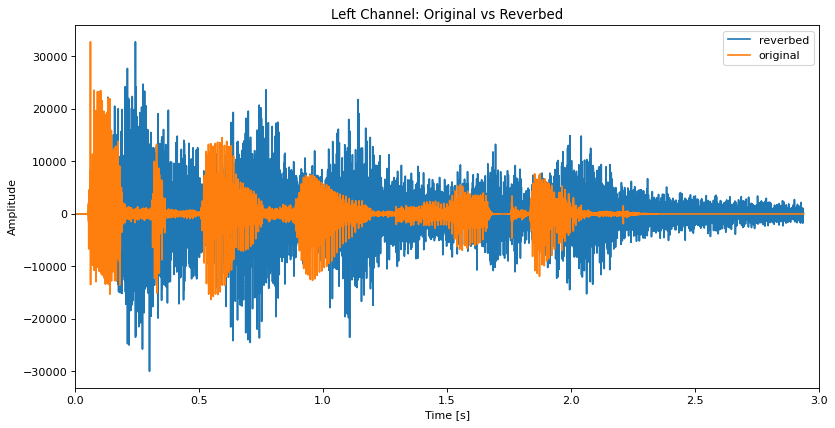

In [196]:
figure(figsize=(12, 6), dpi=80)
time = np.linspace(0., length, data.shape[0])
plt.plot(time, rv_left_data, label="reverbed")
plt.plot(time, left_data, label="original")
plt.xlim(0, 3)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Left Channel: Original vs Reverbed")
plt.show()

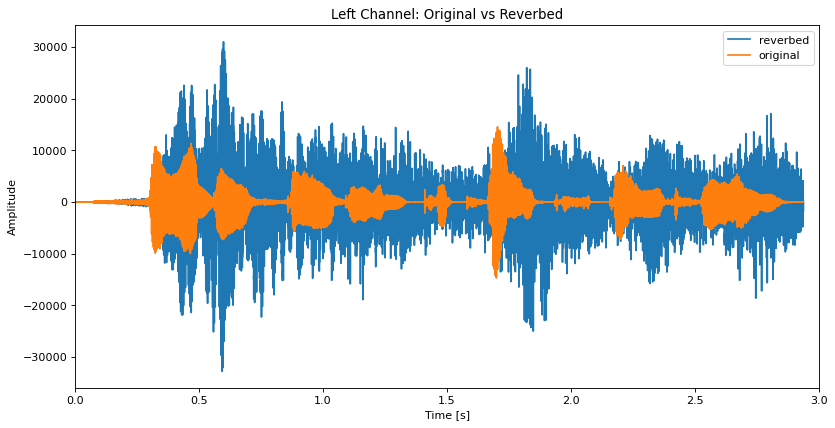

In [197]:
figure(figsize=(12, 6), dpi=80)
time = np.linspace(0., length, data.shape[0])
plt.plot(time, rv_right_data, label="reverbed")
plt.plot(time, right_data, label="original")
plt.xlim(0, 3)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Left Channel: Original vs Reverbed")
plt.show()